# Extra Credit Assignment - Quanwei Gu(quanwei2)  &  Ziqi Li(ziqili3)

In this notebook file, we build and run:


1.   **Non-targeted FGSM**
2.   **Targeted FGSM**











Below, we followed the assignment instruction and ran both the **Non-targeted FGSM** and **targeted FGSM** on the Imagenette.

The basic setup is from the pytorch [tutorial](https://pytorch.org/tutorials/beginner/fgsm_tutorial.html) for gradient sign.

In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import datasets, transforms,models
import numpy as np
import matplotlib.pyplot as plt
from torch.autograd import Variable

Load a pretrained model to start the experiment. Here, we chose ResNet50.

In [ ]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)

# Here, we loaded ResNet as the pretrained model and set it to eval() mode.
model = models.resnet50(pretrained=True).to(device)
model.eval()

cuda:0


ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): Bottleneck(
      (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (downsample): Sequential(
        (0): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 

Then, we need to load the Imagenette dataset to perform the attack. Here, we loaded the 'val' folder of the dataset since there is no need to use the 'train' dataset for our pretrained model. 

In [ ]:
import matplotlib.pyplot as plt
import torch
from torchvision import datasets, transforms

#load val dataset and preprocess
#we resize the images to have shape 224*224
#we also normalized the image following this discussion post:
#https://discuss.pytorch.org/t/how-to-preprocess-input-for-pre-trained-networks/683/18

transform = transforms.Compose([transforms.Resize(224),
                                transforms.CenterCrop(224),
                                transforms.ToTensor(),
                                transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])])
dataset = datasets.ImageFolder('./imagenette2-320/val', transform=transform)
dataloader = torch.utils.data.DataLoader(dataset, batch_size=1, shuffle=True)


## Non-Targeted FGSM Attack

The FGSM was introduced in this [paper](https://arxiv.org/pdf/1412.6572.pdf) in 2015. It computes adversarial images by adding perturbation of some magnitude in the direction of the image gradient. Researchers refer to this method as 'fast' since it computes the perturbation in a single step; thus it is very efficient.

In [ ]:
# fgsm attack code from the pytorch tutorial
def fgsm_attack(image, epsilon, data_grad):
    
    sign_data_grad = data_grad.sign()   # Collect the element-wise sign of the data gradient
    
    perturbed_image = image + epsilon*sign_data_grad    # Create the perturbed image by adjusting each pixel of the input image
    
    perturbed_image = torch.clamp(perturbed_image, 0, 1)    # Adding clipping to maintain [0,1] range
    # Return the perturbed image
    return perturbed_image

The cell below contains the test function from the pytorch tutorial but there are some modifications.

Because the pretrained ResNet was trained on the original Imagenet which contains 1000 different classes, it will give a prediction ranged from 0 to 999 when we forward pass an image. Here, the Imagenette only contains 10 classes. Therefore, we need to pick these 10 classes using indexing. The [imagenette tutorial](https://docs.fast.ai/tutorial.imagenette#Loading-the-data-with-the-mid-level-API) and the [imagenet class info](https://gist.github.com/yrevar/942d3a0ac09ec9e5eb3a) helped us to pick the indices.

In [ ]:
# these indices are the original indices in the imagenet for the 10 classes in the imagenette
indices = [0, 217,482, 491,497,566, 569, 571,574,701]

# fgsm attack test function from the pytorch tutorial with modifications.
def test( model, device, test_loader, epsilon ):

    correct = 0
    adv_examples = []

    # Loop over all examples in test set
    for i, (data, target) in enumerate(test_loader):

        data, target = data.to(device), target.to(device)
        # Set requires_grad attribute of tensor. Important for Attack
        data.requires_grad = True

        # Forward pass the data through the model
        # Here we pick the 10 classes out of 1000 classes
        output = model(data).to(device)[:, indices]

        _, init_pred = torch.max(output,1) # get the index of the max log-probability

        # If the initial prediction is wrong, dont bother attacking, just move on
        if init_pred.item() != target.item():
            continue
        #else:
            #print("true")

        # Calculate the loss
        loss = F.nll_loss(output, target)

        # Zero all existing gradients
        model.zero_grad()

        # Calculate gradients of model in backward pass
        loss.backward()

        # Collect datagrad
        data_grad = data.grad.data

        # Call FGSM Attack
        perturbed_data = fgsm_attack(data, epsilon, data_grad)

        # Re-classify the perturbed image
        output = model(perturbed_data).to(device)[:, indices]

        # Check for success
        _, final_pred = torch.max(output,1) # get the index of the max log-probability

        if final_pred.item() == target.item():
            correct += 1
            # Special case for saving 0 epsilon examples
            if (epsilon == 0) and (len(adv_examples) < 5):
                adv_ex = perturbed_data.squeeze().detach().cpu().numpy()
                adv_examples.append( (init_pred.item(), final_pred.item(), adv_ex) )
        else:
            # Save some adv examples for visualization later
            if len(adv_examples) < 5:
                adv_ex = perturbed_data.squeeze().detach().cpu().numpy()
                adv_examples.append( (init_pred.item(), final_pred.item(), adv_ex) )

    # Calculate final accuracy for this epsilon
    final_acc = correct/float(len(test_loader))
    print("Epsilon: {}\tTest Accuracy = {} / {} = {}".format(epsilon, correct, len(test_loader), final_acc))

    # Return the accuracy and an adversarial example
    return final_acc, adv_examples

**Run** the non-targeted FGSM attack using different values of epsilons.

In [ ]:
# refered from the pytorch tutorial
epsilons = [0, .05, .1, .15, .2, .25, .3]
accuracies = []
examples = []

# Run test for each epsilon
for eps in epsilons:
    print("current eps is: ", eps)
    acc, ex = test(model, device, dataloader, eps)
    accuracies.append(acc)
    examples.append(ex)

current eps is:  0
Epsilon: 0	Test Accuracy = 3219 / 3925 = 0.8201273885350319
current eps is:  0.05
Epsilon: 0.05	Test Accuracy = 2839 / 3925 = 0.7233121019108281
current eps is:  0.1
Epsilon: 0.1	Test Accuracy = 2620 / 3925 = 0.6675159235668789
current eps is:  0.15
Epsilon: 0.15	Test Accuracy = 2387 / 3925 = 0.6081528662420382
current eps is:  0.2
Epsilon: 0.2	Test Accuracy = 2194 / 3925 = 0.5589808917197452
current eps is:  0.25
Epsilon: 0.25	Test Accuracy = 2026 / 3925 = 0.5161783439490446
current eps is:  0.3
Epsilon: 0.3	Test Accuracy = 1897 / 3925 = 0.483312101910828


**Visualize** the results: Accuracy vs Epsilon.

As shown below, when epsilon=0, the fgsm did not have a negative effect on the test accuracy of the pretrained model. However, as we gradually **increase** the value of epsilon, that is, we take bigger steps in the direction that maximize the loss, it turns out that the test accuracy keeps **decreasing** while the images did not change much visually as we can still identify their classes by eyeballing them.


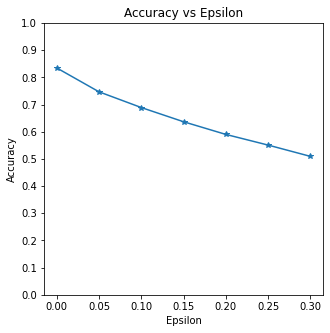

In [ ]:
plt.figure(figsize=(5,5))
plt.plot(epsilons, accuracies, "*-")
plt.yticks(np.arange(0, 1.1, step=0.1))
plt.xticks(np.arange(0, .35, step=0.05))
plt.title("Accuracy vs Epsilon")
plt.xlabel("Epsilon")
plt.ylabel("Accuracy")
plt.show()

As in the tutorial, we also plotted some examples of the adversarial samples at each epsilon. For each image, the initial prediction given by the pretrained model and the prediciton given after the image has been attacked have been displayed above it.

**Note**: Some images shown below are quite dark due to the normalization.

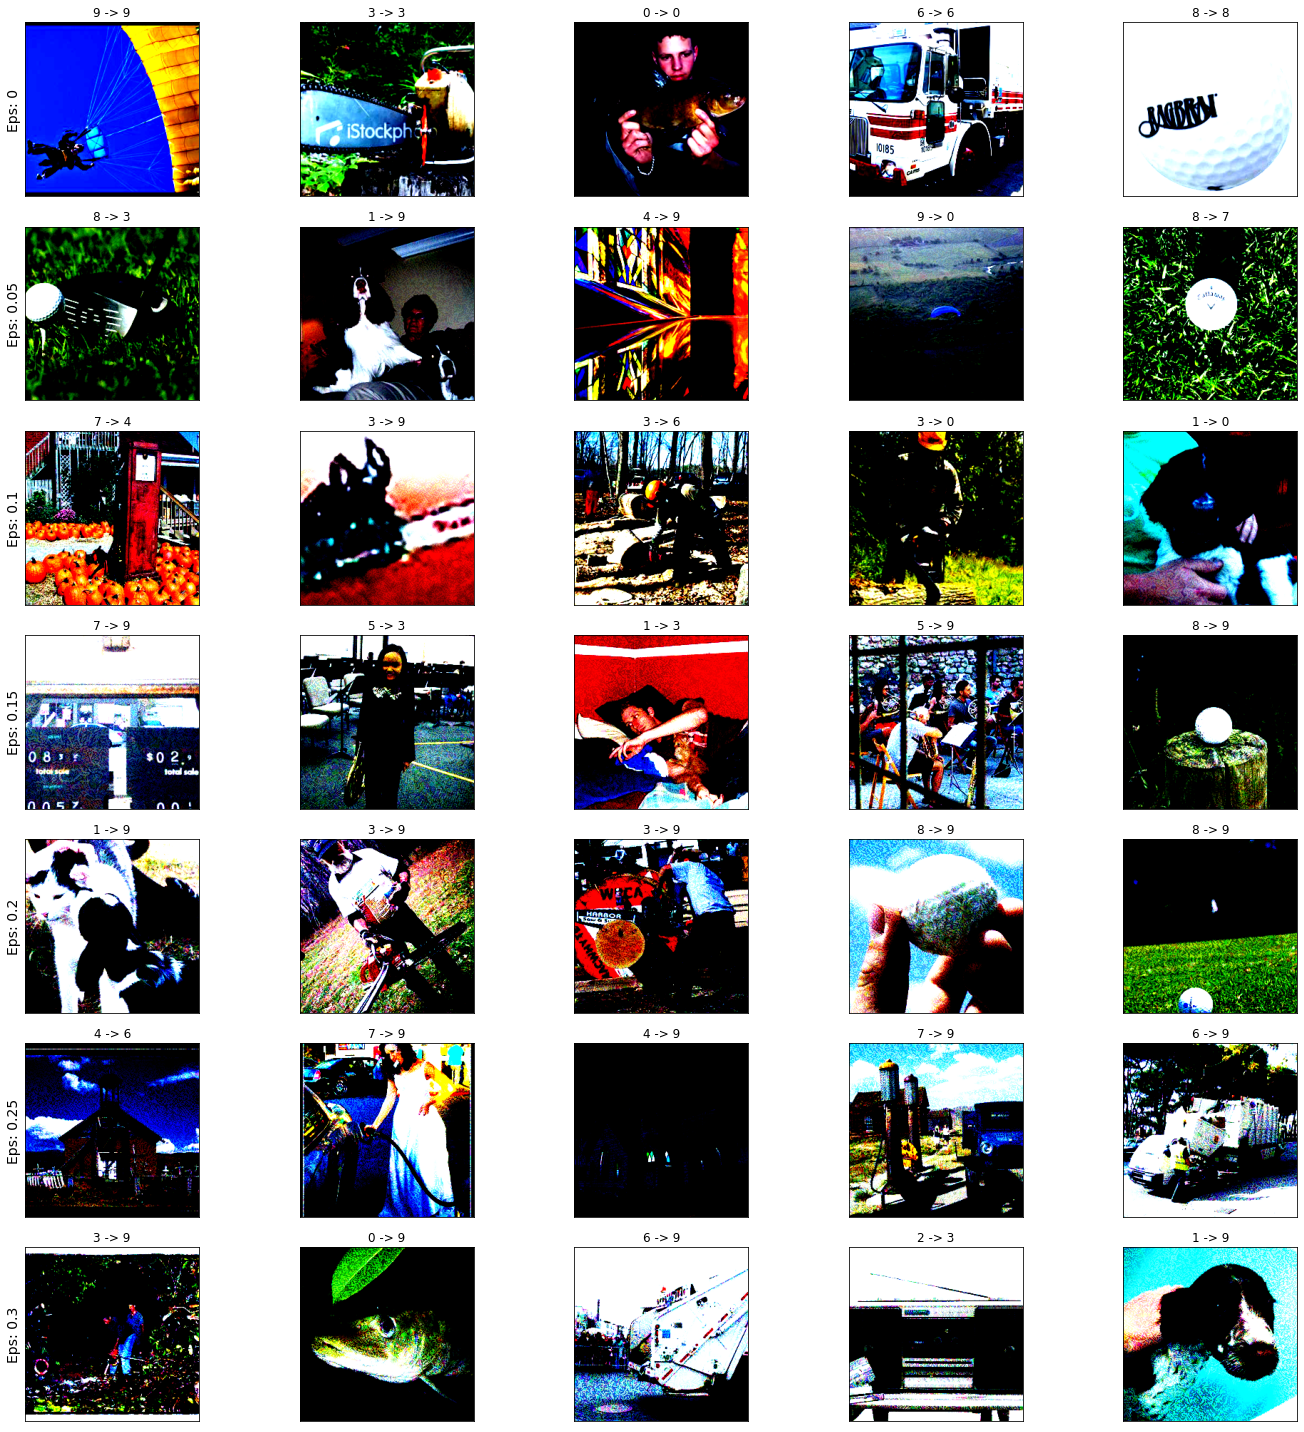

In [ ]:
# Plot several examples of adversarial samples at each epsilon
cnt = 0
plt.figure(figsize=(20,20))
for i in range(len(epsilons)):
    # if i==1:
      # print(examples[i])
    for j in range(len(examples[i])):
        cnt += 1
        plt.subplot(len(epsilons),len(examples[0]),cnt)
        plt.xticks([], [])
        plt.yticks([], [])

        if j == 0:
            plt.ylabel("Eps: {}".format(epsilons[i]), fontsize=14)
        orig,adv,ex = examples[i][j]
        # print(ex.shape)
        plt.title("{} -> {}".format(orig, adv))
        plt.imshow(ex.transpose((1,2,0)))
plt.tight_layout()
plt.show()

## Targeted FGSM Attack

As shown above, the FGSM method makes the pretrained classifier giving wrong predictions by increasing the loss for the true class. The goal of the FGSM method is to lead to misclassification. Here, we implemented a targeted FGSM method which aims to give predictions of a certain target class. The general logic is that we need to **maximize** P(Y_target | X) where X is the acutal image class and Y_target is some target class. Also, the main difference between FGSM and T-FGSM is that, instead of **adding** pertubation to the input image, T-FGSM **substracts** it from the image.

In [ ]:
# T-FGSM Attack

def targeted_fgsm_attack(model, output, image, epsilon, target_label, device, indices):
    
    loss = F.nll_loss(output, target_label) # compute loss
    model.zero_grad()# Zero all existing gradients
    loss.backward()# Calculate gradients of model in backward pass
    data_grad = image.grad.data # Collect datagrad
    perturbed_image = image - epsilon * torch.sign(data_grad)
    perturbed_image = torch.clamp(perturbed_image, 0, 1)
    
    return perturbed_image

In [ ]:
# Test T-FGSM on the pretrained model

indices = [0, 217,482, 491,497,566, 569, 571,574,701]
def target_test( model, device, test_loader, epsilon):

    # Accuracy counter
    correct = 0
    adv_examples = []
    count = 0

    # Loop over all examples in test set
    for i, (data, target) in enumerate(test_loader):
        # print(i)
        data, target = data.to(device), target.to(device)

        # Set requires_grad attribute of tensor. Important for Attack
        data.requires_grad = True

        # Forward pass the data through the model
        output = model(data).to(device)[:, indices]
        
        _, init_pred = torch.max(output,1) # get the index of the max log-probability
        
        ############################
        # Pick a target label, here we picked class 7
        target_label = Variable(torch.LongTensor([7]), requires_grad=False).to(device)
        ############################

        # Call TFGSM Attack
        perturbed_data = targeted_fgsm_attack(model, output, data, epsilon, target_label, device, indices)

        # Re-classify the perturbed image
        output = model(perturbed_data).to(device)[:, indices]
        
        _, final_pred = torch.max(output,1) # get the index of the max log-probability

        if (final_pred.item() != target.item()) and final_pred.item()==target_label.item() :
            count +=1

        if final_pred.item() == target.item():
            correct += 1
            # Special case for saving 0 epsilon examples
            if (epsilon == 0) and (len(adv_examples) < 5):
                adv_ex = perturbed_data.squeeze().detach().cpu().numpy()
                adv_examples.append( (init_pred.item(), final_pred.item(), adv_ex) )
        else:
            # Save some adv examples for visualization later
            if len(adv_examples) < 5:
                adv_ex = perturbed_data.squeeze().detach().cpu().numpy()
                adv_examples.append( (init_pred.item(), final_pred.item(), adv_ex) )

    # Calculate final accuracy for this epsilon
    final_acc = correct/float(len(test_loader))
    print("Epsilon: {}\tTest Accuracy = {} / {} = {}".format(epsilon, correct, len(test_loader), final_acc))
    print("{} images have been targeted to class={}".format(count, target_label.item()))

    # Return the accuracy and an adversarial example
    return final_acc, adv_examples

**Run** and print test accuracies. **Note** that we also printed out the number of images that have been classified as class 7 for each epsilon. As shown below, as the value of epsilon **increases**, the number of images being classified as class 7 also **increases**. Moreover, notice that, among the misclassifications, **significantly more images have been predicted as class 7 compared to other classes**.

In [ ]:
epsilons = [0, .1, .15, 0.5, 0.8]
accuracies = []
examples = []

# Run test for each epsilon
for eps in epsilons:
    #acc, ex = test(model, device, test_loader, eps)
    print("current eps is: ", eps)
    acc, ex = target_test(model, device, dataloader, eps)
    accuracies.append(acc)
    examples.append(ex)

current eps is:  0
Epsilon: 0	Test Accuracy = 3219 / 3925 = 0.8201273885350319
430 images have been targeted to class=7
current eps is:  0.1
Epsilon: 0.1	Test Accuracy = 3007 / 3925 = 0.7661146496815286
543 images have been targeted to class=7
current eps is:  0.15
Epsilon: 0.15	Test Accuracy = 2790 / 3925 = 0.710828025477707
658 images have been targeted to class=7
current eps is:  0.5
Epsilon: 0.5	Test Accuracy = 1832 / 3925 = 0.4667515923566879
1235 images have been targeted to class=7
current eps is:  0.8
Epsilon: 0.8	Test Accuracy = 1420 / 3925 = 0.36178343949044584
1448 images have been targeted to class=7


**Plot** Accuracy vs Epsilon

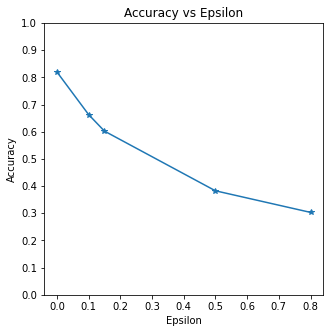

In [ ]:
plt.figure(figsize=(5,5))
plt.plot(epsilons, accuracies, "*-")
plt.yticks(np.arange(0, 1.1, step=0.1))
plt.xticks(np.arange(0, .85, step=0.1))
plt.title("Accuracy vs Epsilon")
plt.xlabel("Epsilon")
plt.ylabel("Accuracy")
plt.show()